In [1]:
import os
print(os.getcwd())

d:\Desktop\Skripsi\FERflask


In [2]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
img = cv.imread("Dataset/happiness/S026_006_00000013.png")
# opencv BGR channel format and plt reads images as RGB channel format

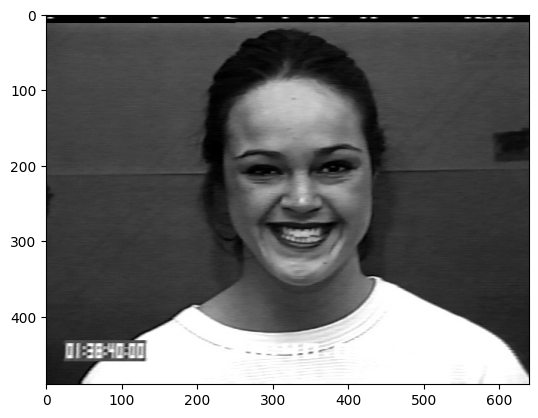

In [4]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

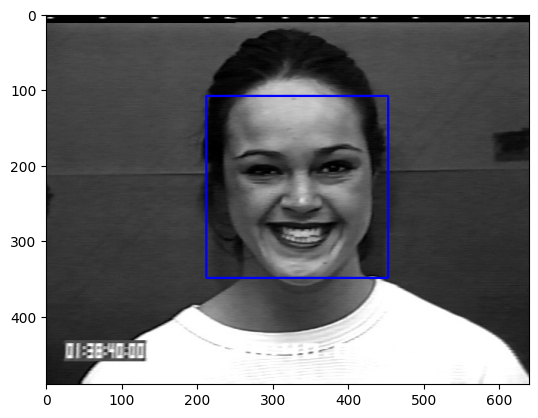

In [5]:
import cv2 as cv

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
     cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

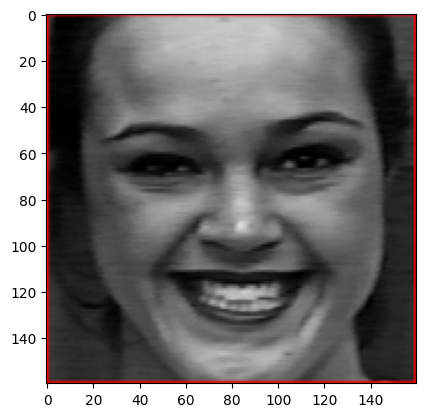

In [6]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [7]:
my_face

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [141,  33,  33],
        [ 98,  37,  37],
        ...,
        [122,  61,  61],
        [122,  61,  61],
        [221,  16,  16]],

       [[255,   0,   0],
        [104,  42,  42],
        [ 43,  43,  43],
        ...,
        [ 71,  71,  71],
        [ 73,  73,  73],
        [209,  19,  19]],

       ...,

       [[255,   0,   0],
        [105,  43,  43],
        [ 56,  56,  56],
        ...,
        [ 42,  42,  42],
        [ 44,  44,  44],
        [201,  11,  11]],

       [[255,   0,   0],
        [102,  41,  41],
        [ 54,  54,  54],
        ...,
        [ 44,  44,  44],
        [ 48,  48,  48],
        [203,  12,  12]],

       [[255,   0,   0],
        [217,  11,  11],
        [205,  14,  14],
        ...,
        [200,  10,  10],
        [201,  11,  11],
        [242,   3,   3]]

#AUTOMATE PREPROCESSING

In [8]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

        # Detect faces using the Haar Cascade detector
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(160, 160))

        if len(faces) > 0:
            x, y, w, h = faces[0]  # Assuming only one face is detected
            face = img[y:y + h, x:x + w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        else:
            return None


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_face(path)
                if single_face is not None:
                    FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18, 16))
        for num, image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y) // ncols + 1
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')

In [9]:
faceloading = FACELOADING("ck low")
X, Y = faceloading.load_classes()

Loaded successfully: 90
Loaded successfully: 75
Loaded successfully: 75
Loaded successfully: 105
Loaded successfully: 160
Loaded successfully: 84
Loaded successfully: 166


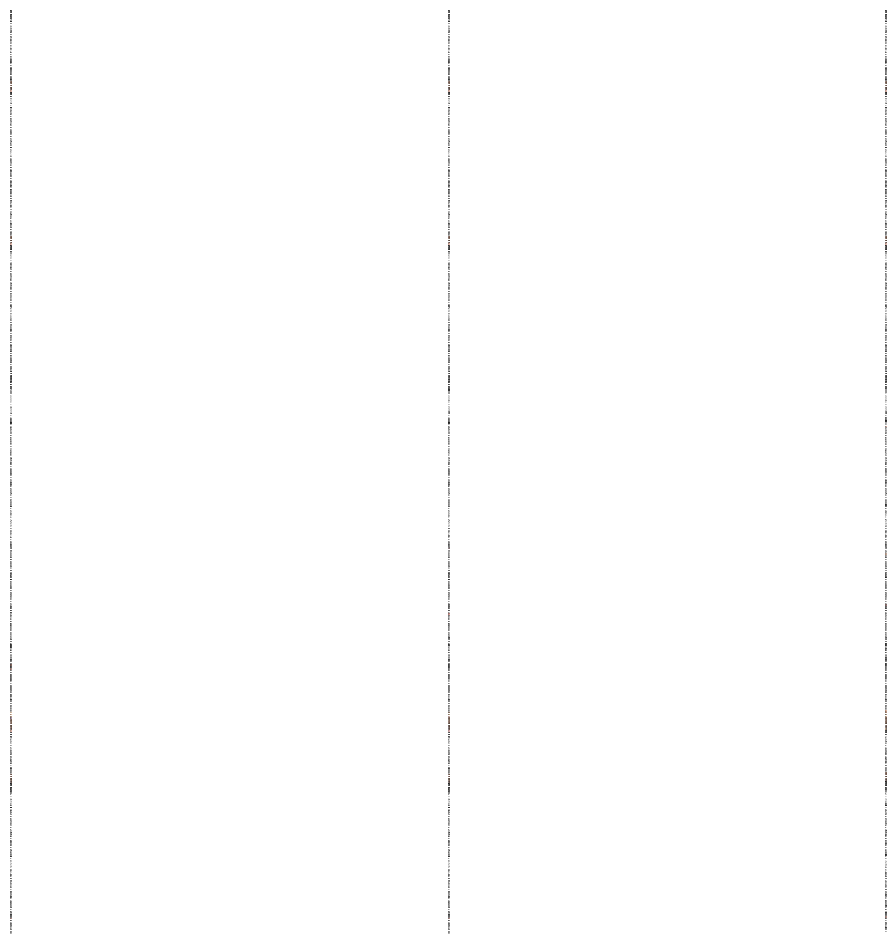

In [23]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

#FaceNet

In [9]:
%pip install keras-facenet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [ ]:
from keras.models import load_model

MyFaceNet = load_model('facenet_keras.h5')


In [24]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 60ms/step


In [31]:
np.savez_compressed('faces_embeddings_done_7expressions.npz', EMBEDDED_X, Y)

#SVM MODEL

In [32]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

In [33]:
Y

array([0, 0, 0, ..., 6, 6, 6])

Text(0, 0.5, '0')

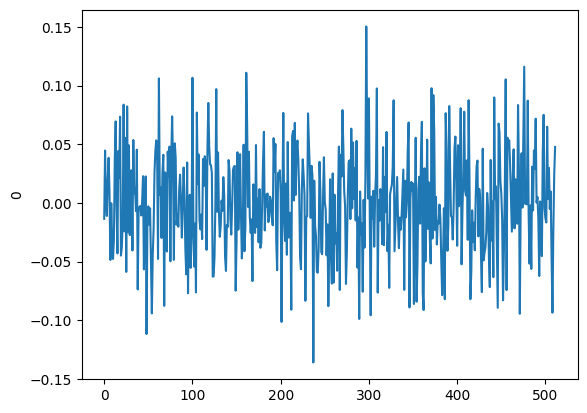

In [34]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, test_size=0.2, shuffle=True)

In [80]:
from sklearn.svm import SVC
model = SVC(kernel='poly', C=1, probability=True, class_weight='balanced')
model.fit(X_train, Y_train)

SVC(C=1, class_weight='balanced', kernel='poly', probability=True)

In [81]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

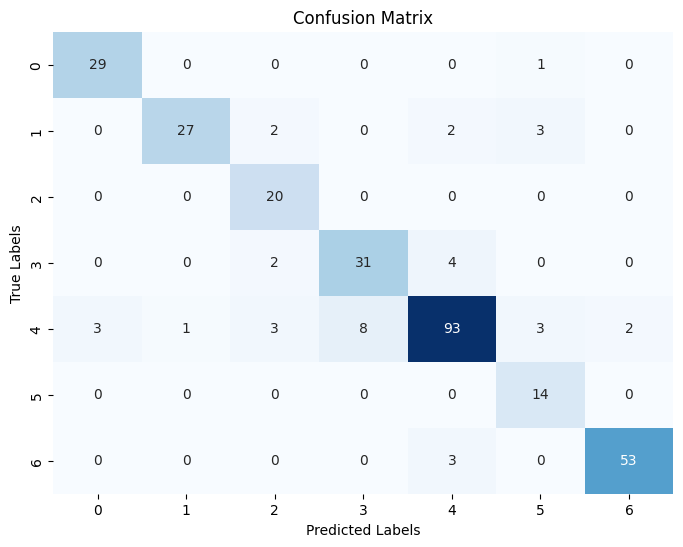

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test data
Y_pred = model.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [84]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

0.9473684210526315

In [85]:
accuracy_score(Y_test,ypreds_test)

0.8782894736842105

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Assuming you have your data loaded as X and y
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=17)

# Train a linear SVM model on your data
model = SVC(kernel='linear', probability=True, decision_function_shape='ovr')
model.fit(X_train, y_train)

# Create a mesh to plot the decision boundary
h = 0.02  # Step size in the mesh
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Get decision boundary values for the mesh
mesh_data = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(mesh_data)
Z = Z.reshape(xx.shape)

# Plot the data points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired)

# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear SVM Decision Boundary for Your Data')

# Show the plot
plt.show()



TypeError: ignored

In [ ]:
print(X_train.shape)


(1064, 512)


In [ ]:
# Load the image
t_im = cv.imread("/content/drive/MyDrive/FERSkripsi/Dataset/neutral/S157_002_00000001.png")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(t_im, cv.COLOR_RGB2GRAY)

# Detect faces using the Haar Cascade detector
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

if len(faces) > 0:
    x, y, w, h = faces[0]  # Assuming only one face is detected
    # You can now work with the detected face's coordinates (x, y, w, h)
else:
    print("No faces detected in the image.")

In [ ]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 118ms/step


In [ ]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [ ]:
ypreds

array([4])

In [ ]:
encoder.inverse_transform(ypreds)

array(['neutral'], dtype='<U9')

In [ ]:
import cv2
import numpy as np
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import joblib
from numpy import expand_dims
import os


# Function to extract face from a given photograph using Haar Cascade and resize it
def extract_face(filename, required_size=(160, 160)):
    image = cv2.imread(filename)
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(160, 160))

    if len(faces) == 0:
        return None

    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, required_size)
    return face

# Load the FaceNet model
MyFaceNet = FaceNet()

# Load the trained SVM model and label encoder
model = joblib.load('svm_model_7expressions.pkl')
label_encoder = joblib.load('label_encoder_7expressions.pkl')

# Load and extract faces from the new data folder
new_data_folder = "real"
new_faces = []
for filename in os.listdir(new_data_folder):
    path = os.path.join(new_data_folder, filename)
    face = extract_face(path)
    if face is not None:
        new_faces.append(face)

# Convert faces to embeddings
new_faces_embeddings = [MyFaceNet.embeddings(expand_dims(face, axis=0))[0] for face in new_faces]

# Predict labels using the trained model
predicted_labels = model.predict(new_faces_embeddings)

# Decode numerical labels to original string labels
predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)

# Print the predicted labels for each face
for filename, label in zip(os.listdir(new_data_folder), predicted_labels_decoded):
    print(f"{filename}: Predicted Expression - {label}")
